# Weather prediction dataset - regression task: tomorrow sunshine hours 
- using full dataset
- using BatchNormalization & Dropout & Early Stopping
- using Monte-Carlo Dropout

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

In [2]:
path_root = os.path.dirname(os.getcwd())
path_data = os.path.join(path_root, "dataset")
filename_data = os.path.join(path_data, "weather_prediction_dataset.csv")

In [3]:
data = pd.read_csv(filename_data)
data.head()

,DATE,MONTH,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,...,STOCKHOLM_temp_min,STOCKHOLM_temp_max,TOURS_wind_speed,TOURS_humidity,TOURS_pressure,TOURS_global_radiation,TOURS_precipitation,TOURS_temp_mean,TOURS_temp_min,TOURS_temp_max
0,20000101,1,8,0.89,1.0286,0.20,0.03,0.0,2.9,1.6,...,-9.3,0.7,1.6,0.97,1.0275,0.25,0.04,8.5,7.2,9.8
1,20000102,1,8,0.87,1.0318,0.25,0.00,0.0,3.6,2.7,...,0.5,2.0,2.0,0.99,1.0293,0.17,0.16,7.9,6.6,9.2
2,20000103,1,5,0.81,1.0314,0.50,0.00,3.7,2.2,0.1,...,-1.0,2.8,3.4,0.91,1.0267,0.27,0.00,8.1,6.6,9.6
3,20000104,1,7,0.79,1.0262,0.63,0.35,6.9,3.9,0.5,...,2.5,4.6,4.9,0.95,1.0222,0.11,0.44,8.6,6.4,10.8
4,20000105,1,5,0.90,1.0246,0.51,0.07,3.7,6.0,3.8,...,-1.8,2.9,3.6,0.95,1.0209,0.39,0.04,8.0,6.4,9.5


In [4]:
data.shape

(3654, 165)

# Split data into data (X) and labels (y)
We here want to predict the sunshine hours for a particular place (say BASEL which is about in the center of all 18 locations). 

In [5]:
# data
X_data = data.loc[:(data.shape[0]-2)].drop(columns=['DATE', 'MONTH'])

# labels (sunshine hours the next day)
y_data = data.loc[1:]["BASEL_sunshine"] #["BASEL_temp_max"]#["BASEL_global_radiation"]

X_data.shape, y_data.shape

((3653, 163), (3653,))

In [6]:
X_data.head()

,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,BASEL_temp_max,BUDAPEST_cloud_cover,...,STOCKHOLM_temp_min,STOCKHOLM_temp_max,TOURS_wind_speed,TOURS_humidity,TOURS_pressure,TOURS_global_radiation,TOURS_precipitation,TOURS_temp_mean,TOURS_temp_min,TOURS_temp_max
0,8,0.89,1.0286,0.20,0.03,0.0,2.9,1.6,3.9,3,...,-9.3,0.7,1.6,0.97,1.0275,0.25,0.04,8.5,7.2,9.8
1,8,0.87,1.0318,0.25,0.00,0.0,3.6,2.7,4.8,8,...,0.5,2.0,2.0,0.99,1.0293,0.17,0.16,7.9,6.6,9.2
2,5,0.81,1.0314,0.50,0.00,3.7,2.2,0.1,4.8,6,...,-1.0,2.8,3.4,0.91,1.0267,0.27,0.00,8.1,6.6,9.6
3,7,0.79,1.0262,0.63,0.35,6.9,3.9,0.5,7.5,8,...,2.5,4.6,4.9,0.95,1.0222,0.11,0.44,8.6,6.4,10.8
4,5,0.90,1.0246,0.51,0.07,3.7,6.0,3.8,8.6,5,...,-1.8,2.9,3.6,0.95,1.0209,0.39,0.04,8.0,6.4,9.5


In [7]:
X_data.describe()

,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,BASEL_temp_max,BUDAPEST_cloud_cover,...,STOCKHOLM_temp_min,STOCKHOLM_temp_max,TOURS_wind_speed,TOURS_humidity,TOURS_pressure,TOURS_global_radiation,TOURS_precipitation,TOURS_temp_mean,TOURS_temp_min,TOURS_temp_max
count,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,...,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000
mean,5.417739,0.745056,1.017882,1.330723,0.234760,4.662469,11.025021,6.991103,15.539721,4.890227,...,5.108021,11.475691,3.677334,0.781851,1.016643,1.370131,0.186151,12.209006,7.862880,16.555817
std,2.325423,0.107759,0.007956,0.935247,0.536314,4.330018,7.414550,6.653203,8.720706,2.386698,...,7.248085,8.946221,1.520067,0.115581,0.018886,0.926365,0.422198,6.465138,5.691272,7.712116
min,0.000000,0.380000,0.985600,0.050000,0.000000,0.000000,-9.300000,-16.000000,-5.700000,0.000000,...,-19.700000,-14.500000,0.700000,0.330000,0.000300,0.050000,0.000000,-6.200000,-13.000000,-3.100000
25%,4.000000,0.670000,1.013300,0.530000,0.000000,0.500000,5.300000,2.000000,8.700000,3.000000,...,0.000000,4.100000,2.600000,0.700000,1.012100,0.550000,0.000000,7.600000,3.700000,10.800000
50%,6.000000,0.760000,1.017700,1.110000,0.000000,3.600000,11.400000,7.300000,15.800000,5.000000,...,5.000000,11.000000,3.400000,0.800000,1.017300,1.240000,0.000000,12.300000,8.300000,16.600000
75%,7.000000,0.830000,1.022700,2.060000,0.210000,8.000000,16.900000,12.400000,22.300000,7.000000,...,11.200000,19.000000,4.600000,0.870000,1.022200,2.090000,0.160000,17.200000,12.300000,22.400000
max,8.000000,0.980000,1.040800,3.550000,7.570000,15.300000,29.000000,20.800000,38.600000,8.000000,...,21.200000,32.900000,10.800000,1.000000,1.041400,3.560000,6.200000,31.200000,22.600000,39.800000


<AxesSubplot:>

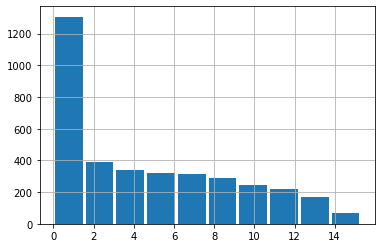

In [8]:
y_data.hist(rwidth=0.9)

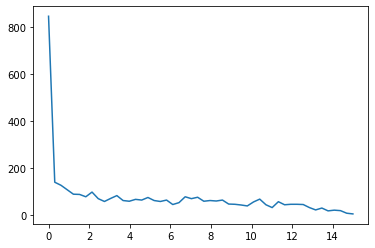

In [9]:
a, b = np.histogram(y_data, 50)
plt.plot(b[:-1], a)

In [23]:
from numpy.polynomial import polynomial as P

#c, stats = P.polyfit(b[:-1], a, 3,full=True)
p = np.poly1d(np.polyfit(b[:-1], a, 5))

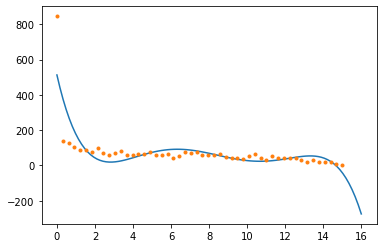

In [24]:
xint = np.linspace(0,16,100)

plt.plot(xint, p(xint))
plt.plot(b[:-1], a, ".")

In [38]:
from scipy.optimize import curve_fit

def func(x, a, b, c, d):
    return a * np.exp(-b * x) + c * x + d

In [41]:
popt, pcov = curve_fit(func, b[:-1], a, p0=[800, 10, -5, 10])

In [42]:
popt

array([751.94850332,   8.78315937,  -4.93143241,  93.89400723])

In [43]:
func(0.01, *popt)

782.5656887695328

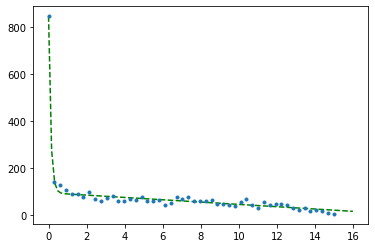

In [44]:
xint = np.linspace(0,16,100)

plt.plot(xint, func(xint, *popt), 'g--')
plt.plot(b[:-1], a, ".")

In [45]:
xint = np.linspace(0,16,100)
from scipy.interpolate import interp1d
f = interp1d(b[:-1], a)

ValueError: A value in x_new is above the interpolation range.

846


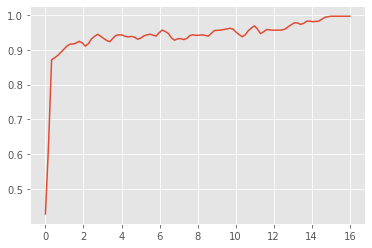

In [58]:
a, b = np.histogram(y_data, 50)
#plt.plot(b[:-1], a)

maxvalue = np.max(a)
print(maxvalue)
xint = np.linspace(0,16,100)
yint = np.interp(xint, b[:-1], a)
plt.plot(xint, np.exp(-0.001*yint))

In [54]:
import tensorflow as tf

def custom_loss_function(y_true, y_pred):
    a, b, c, d = (751.94850332,   8.78315937,  -4.93143241,  93.89400723)
    fitresults = a * np.exp(-b * y_true) + c * y_true + d
    squared_difference = np.exp(-0.001 * fitresults) * np.square(y_true - y_pred)#tf.square(y_true - y_pred)
    return tf.reduce_mean(squared_difference, axis=-1)

y_true = [2, 10, 12.2, 0.]
y_pred = [6.5, 14., 15., 6]
cl = custom_loss_function(np.array(y_true),np.array(y_pred))
cl.numpy()

14.237824406661725

In [60]:
model.compile(optimizer='adam', loss=custom_loss_function)

# Split data into training, validation, and test set

In [47]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=0) 
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

print(f"Data split into training ({X_train.shape[0]})," \
      f" validation ({X_val.shape[0]}) and test set ({X_test.shape[0]}).") 

Data split into training (2557), validation (548) and test set (548).


In [48]:
# this also shuffled the data!
y_train[:10]

746     0.0
3188    2.8
1982    2.0
3396    6.0
2683    0.2
848     3.3
3328    0.7
1255    8.2
3618    0.1
3082    9.2
Name: BASEL_sunshine, dtype: float64

In [49]:
y_train.max(), y_train.min()

(15.3, 0.0)

# Build neural network

In [50]:
from tensorflow.keras.layers import Dense, Input, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [51]:
X_train.shape, y_train.shape

((2557, 163), (2557,))

## Measure model uncertainty using Monte-Carlo Dropout
- how to evaluate the model prediction uncertainty

In [55]:
from tensorflow.keras.layers import Dropout

def create_nn(n_features, n_predictions):
    # Input layer
    layers_input = Input(shape=(n_features,), name='input')

    # Dense layers
    layers_dense = BatchNormalization()(layers_input)
    layers_dense = Dense(100, 'relu')(layers_dense)
    layers_dense = Dropout(rate=0.2)(layers_dense, training=True)
    layers_dense = Dense(50, 'relu')(layers_dense)
    layers_dense = Dropout(rate=0.2)(layers_dense, training=True)
    layers_dense = Dense(10, 'relu')(layers_dense)
    
    # Output layer
    layers_output = Dense(n_predictions)(layers_dense)

    # Defining the model and compiling it
    return Model(inputs=layers_input, outputs=layers_output, name="dropout_prediction_model")

model = create_nn(X_data.shape[1], 1)
model.compile(loss=custom_loss_function, #'mse',
              optimizer=Adam(1e-4), metrics=[tf.keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "dropout_prediction_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 163)]             0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 163)               652       
_________________________________________________________________
dense_4 (Dense)              (None, 100)               16400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)   

In [56]:
from tensorflow.keras.callbacks import EarlyStopping

earlystopper = EarlyStopping(
    monitor='val_loss', mode="min",
    patience=20,
    verbose=1
    )

history = model.fit(X_train, y_train,
                    batch_size = 32,
                    epochs = 1000,
                    validation_data=(X_val, y_val),
                    callbacks=[earlystopper],
                    verbose = 2)

Epoch 1/1000


NotImplementedError: in user code:

    c:\users\florianhuber\anaconda3\envs\ms2deepscore\lib\site-packages\tensorflow\python\keras\engine\training.py:805 train_function  *
        return step_function(self, iterator)
    <ipython-input-54-0f8ed9294a4a>:5 custom_loss_function  *
        fitresults = a * np.exp(-b * y_true) + c * y_true + d
    c:\users\florianhuber\anaconda3\envs\ms2deepscore\lib\site-packages\tensorflow\python\framework\ops.py:852 __array__  **
        raise NotImplementedError(

    NotImplementedError: Cannot convert a symbolic Tensor (custom_loss_function/mul:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported


Text(0, 0.5, 'RMSE')

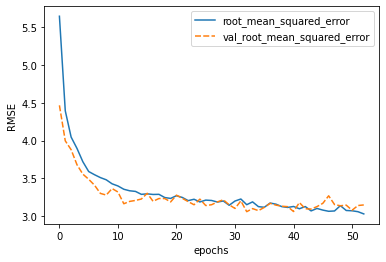

In [16]:
import seaborn as sns

history_df = pd.DataFrame.from_dict(history.history)
sns.lineplot(data=history_df[['root_mean_squared_error', 'val_root_mean_squared_error']])
plt.xlabel("epochs")
plt.ylabel("RMSE")

Text(0, 0.5, 'true sunshine hours')

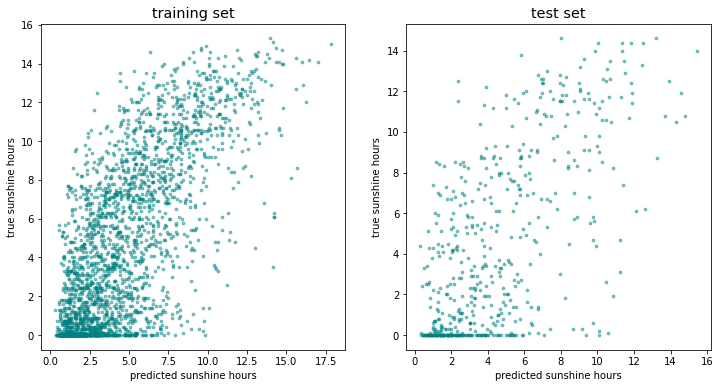

In [17]:
# Predict the sunshine hours
y_train_predicted = model.predict(X_train)
y_test_predicted = model.predict(X_test)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plt.style.use('ggplot')
axes[0].scatter(y_train_predicted, y_train, s=10, alpha=0.5, color="teal")
axes[0].set_title("training set")
axes[0].set_xlabel("predicted sunshine hours")
axes[0].set_ylabel("true sunshine hours")

axes[1].scatter(y_test_predicted, y_test, s=10, alpha=0.5, color="teal")
axes[1].set_title("test set")
axes[1].set_xlabel("predicted sunshine hours")
axes[1].set_ylabel("true sunshine hours")

#plt.savefig("03_regression_compare_training_test_3_dropout.png", dpi=200)

In [18]:
from tqdm.notebook import tqdm

n_ensemble = 100
y_test_predicted_ensemble = np.zeros((X_test.shape[0], n_ensemble))

for i in tqdm(range(n_ensemble)):
    y_test_predicted_ensemble[:, i] = model.predict(X_test)[:,0]

  0%|          | 0/100 [00:00<?, ?it/s]

(array([ 3.,  3.,  9., 13., 12., 14., 13., 17., 11.,  5.]),
 array([2.6711967 , 2.99684837, 3.32250004, 3.64815171, 3.97380338,
        4.29945505, 4.62510672, 4.95075839, 5.27641006, 5.60206172,
        5.92771339]),
 <BarContainer object of 10 artists>)

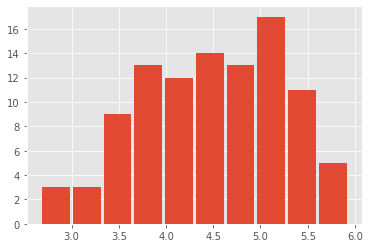

In [19]:
plt.hist(y_test_predicted_ensemble[0,:], rwidth=0.9)

In [20]:
y_test_predicted_mean = np.mean(y_test_predicted_ensemble, axis=1)
y_test_predicted_std = np.std(y_test_predicted_ensemble, axis=1)

In [21]:
y_test_predicted_std.min(), y_test_predicted_std.max()

(0.20395606494935742, 1.8838728495582353)

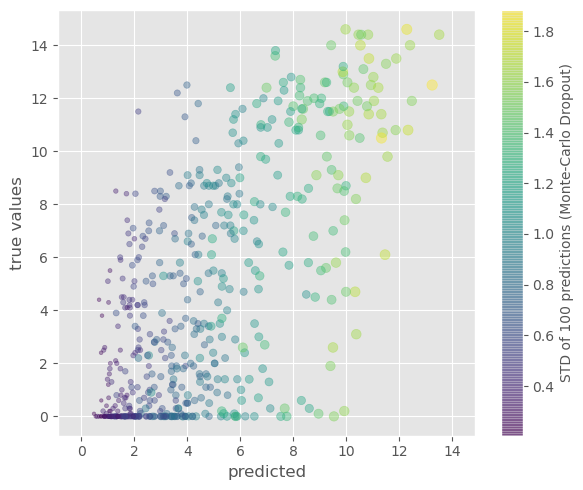

In [22]:
fig, ax = plt.subplots(figsize=(6, 5), dpi=100)
plt.scatter(y_test_predicted_mean, y_test, s=30*y_test_predicted_std, 
            c=y_test_predicted_std, alpha=0.4)
plt.xlabel("predicted")
plt.ylabel("true values")
cbar = plt.colorbar()
cbar.set_label('STD of 100 predictions (Monte-Carlo Dropout)', rotation=90, fontsize=10)

ax.axis("equal")
fig.tight_layout()
#plt.savefig("sunshine_tomorrow_monte_carlo_dropout.png", dpi=300)

## Same but now predicting global radiation

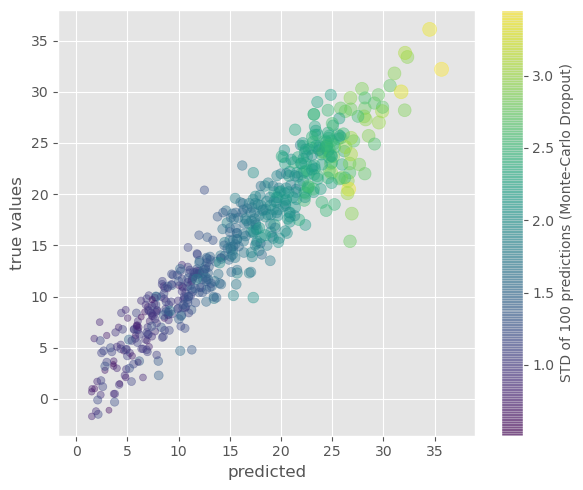

In [90]:
fig, ax = plt.subplots(figsize=(6, 5), dpi=100)
plt.scatter(y_test_predicted_mean, y_test, s=30*y_test_predicted_std, 
            c=y_test_predicted_std, alpha=0.4)
plt.xlabel("predicted")
plt.ylabel("true values")
cbar = plt.colorbar()
cbar.set_label('STD of 100 predictions (Monte-Carlo Dropout)', rotation=90, fontsize=10)

ax.axis("equal")
fig.tight_layout()
#plt.savefig("sunshine_tomorrow_monte_carlo_dropout.png", dpi=300)

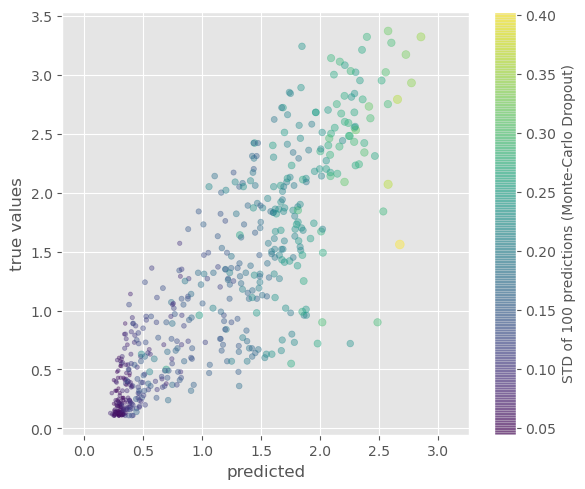

In [68]:
fig, ax = plt.subplots(figsize=(6, 5), dpi=100)
plt.scatter(y_test_predicted_mean, y_test, s=100*y_test_predicted_std, 
            c=y_test_predicted_std, alpha=0.4)
plt.xlabel("predicted")
plt.ylabel("true values")
cbar = plt.colorbar()
cbar.set_label('STD of 100 predictions (Monte-Carlo Dropout)', rotation=90, fontsize=10)

ax.axis("equal")
fig.tight_layout()
#plt.savefig("sunshine_tomorrow_monte_carlo_dropout.png", dpi=300)

Text(0, 0.5, 'true values')

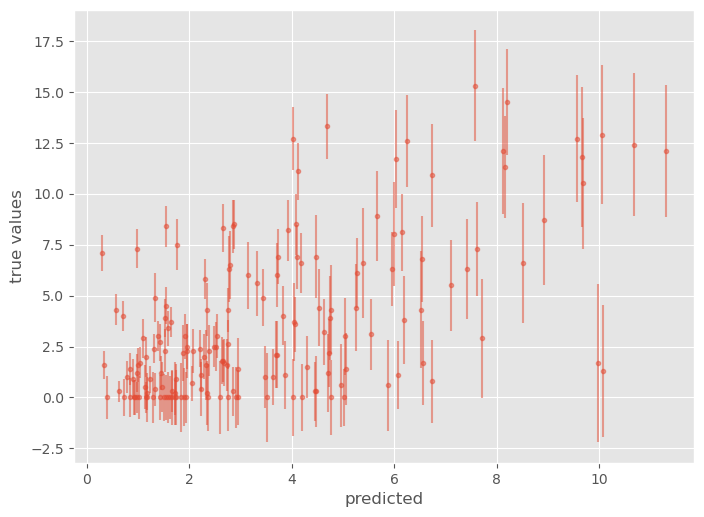

In [157]:
plt.figure(figsize=(8, 6), dpi=100)
plt.errorbar(y_test_predicted_mean, y_test, yerr=2*y_test_predicted_std, marker=".", ls="", alpha=0.5)
plt.xlabel("predicted")
plt.ylabel("true values")

# Consider problem of unbalanced data

(array([252.,  78.,  57.,  50.,  62.,  44.,  45.,  43.,  22.,  23.,  21.,
         22.,  23.,   7.,  13.,   5.,   0.,   0.,   0.,   0.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20.]),
 <BarContainer object of 20 artists>)

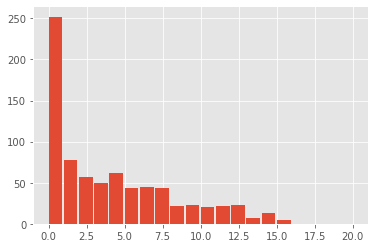

In [58]:
plt.hist(y_train, np.linspace(0,20,21), width=0.9)

In [68]:
np.where(y_train < 1)[0].shape

(252,)

In [84]:
undersampling_remove = np.random.choice(np.where(y_train < 1)[0], 150, replace=False)
keep_idx = np.asarray([i for i in range(y_train.shape[0]) if i not in undersampling_remove])

X_train_undersampling = X_train.values[keep_idx,:]
y_train_undersampling = y_train.values[keep_idx]

(array([102.,  78.,  57.,  50.,  62.,  44.,  45.,  43.,  22.,  23.,  21.,
         22.,  23.,   7.,  13.,   5.,   0.,   0.,   0.,   0.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20.]),
 <BarContainer object of 20 artists>)

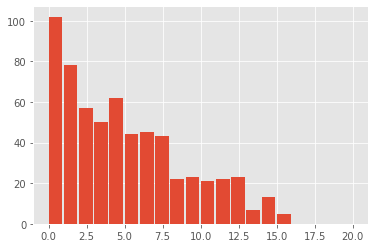

In [85]:
plt.hist(y_train_undersampling, np.linspace(0,20,21), width=0.9)

In [104]:
from tensorflow.keras.layers import Dropout

def create_nn(n_features, n_predictions):
    # Input layer
    layers_input = Input(shape=(n_features,), name='input')

    # Dense layers
    layers_dense = BatchNormalization()(layers_input)
    layers_dense = Dense(100, 'relu')(layers_dense)
    layers_dense = Dropout(rate=0.2)(layers_dense)
    layers_dense = Dense(50, 'relu')(layers_dense)
    layers_dense = Dropout(rate=0.2)(layers_dense)
    layers_dense = Dense(10, 'relu')(layers_dense)

    # Output layer
    layers_output = Dense(n_predictions)(layers_dense)

    # Defining the model and compiling it
    return Model(inputs=layers_input, outputs=layers_output, name="dropout_prediction_model")

model = create_nn(X_data.shape[1], 1)
model.compile(loss='mse', optimizer=Adam(1e-4), metrics=[tf.keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "dropout_prediction_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 163)]             0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 163)               652       
_________________________________________________________________
dense_39 (Dense)             (None, 100)               16400     
_________________________________________________________________
dropout_14 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_15 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_41 (Dense)             (None, 10)   

In [105]:
earlystopper = EarlyStopping(
    monitor='val_loss', mode="min",
    patience=20,
    verbose=1
    )

history = model.fit(X_train_undersampling, y_train_undersampling,
                    batch_size = 50,
                    epochs = 1000,
                    validation_data=(X_val, y_val),
                    callbacks=[earlystopper],
                    verbose = 2)

Epoch 1/1000
13/13 - 2s - loss: 34.2113 - root_mean_squared_error: 5.8490 - val_loss: 13.8586 - val_root_mean_squared_error: 3.7227
Epoch 2/1000
13/13 - 0s - loss: 31.3042 - root_mean_squared_error: 5.5950 - val_loss: 13.0016 - val_root_mean_squared_error: 3.6058
Epoch 3/1000
13/13 - 0s - loss: 28.4667 - root_mean_squared_error: 5.3354 - val_loss: 12.8447 - val_root_mean_squared_error: 3.5840
Epoch 4/1000
13/13 - 0s - loss: 25.3701 - root_mean_squared_error: 5.0369 - val_loss: 12.7878 - val_root_mean_squared_error: 3.5760
Epoch 5/1000
13/13 - 0s - loss: 23.4982 - root_mean_squared_error: 4.8475 - val_loss: 12.8109 - val_root_mean_squared_error: 3.5792
Epoch 6/1000
13/13 - 0s - loss: 21.0539 - root_mean_squared_error: 4.5885 - val_loss: 12.8842 - val_root_mean_squared_error: 3.5895
Epoch 7/1000
13/13 - 0s - loss: 18.9304 - root_mean_squared_error: 4.3509 - val_loss: 13.0241 - val_root_mean_squared_error: 3.6089
Epoch 8/1000
13/13 - 0s - loss: 17.1082 - root_mean_squared_error: 4.1362 - 

13/13 - 0s - loss: 9.1634 - root_mean_squared_error: 3.0271 - val_loss: 8.8231 - val_root_mean_squared_error: 2.9704
Epoch 64/1000
13/13 - 0s - loss: 9.0772 - root_mean_squared_error: 3.0128 - val_loss: 8.7896 - val_root_mean_squared_error: 2.9647
Epoch 65/1000
13/13 - 0s - loss: 8.8154 - root_mean_squared_error: 2.9691 - val_loss: 8.7919 - val_root_mean_squared_error: 2.9651
Epoch 66/1000
13/13 - 0s - loss: 9.3741 - root_mean_squared_error: 3.0617 - val_loss: 8.7916 - val_root_mean_squared_error: 2.9651
Epoch 67/1000
13/13 - 0s - loss: 9.6183 - root_mean_squared_error: 3.1013 - val_loss: 8.8238 - val_root_mean_squared_error: 2.9705
Epoch 68/1000
13/13 - 0s - loss: 9.1786 - root_mean_squared_error: 3.0296 - val_loss: 8.8158 - val_root_mean_squared_error: 2.9691
Epoch 69/1000
13/13 - 0s - loss: 8.8658 - root_mean_squared_error: 2.9776 - val_loss: 8.8016 - val_root_mean_squared_error: 2.9668
Epoch 70/1000
13/13 - 0s - loss: 8.7467 - root_mean_squared_error: 2.9575 - val_loss: 8.7808 - va

Text(0, 0.5, 'RMSE')

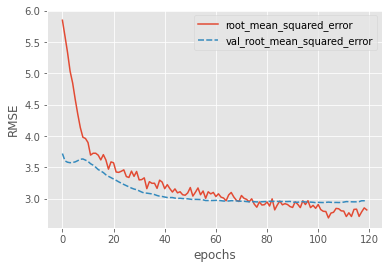

In [106]:
history_df = pd.DataFrame.from_dict(history.history)
sns.lineplot(data=history_df[['root_mean_squared_error', 'val_root_mean_squared_error']])
plt.xlabel("epochs")
plt.ylabel("RMSE")
#plt.savefig("03_training_history_5_rmse_dropout_oversampling.png", dpi=200)

In [107]:
# Predict the sunshine hours
y_train_predicted = model.predict(X_train_undersampling)
y_test_predicted = model.predict(X_test)

Text(0, 0.5, 'true sunshine hours')

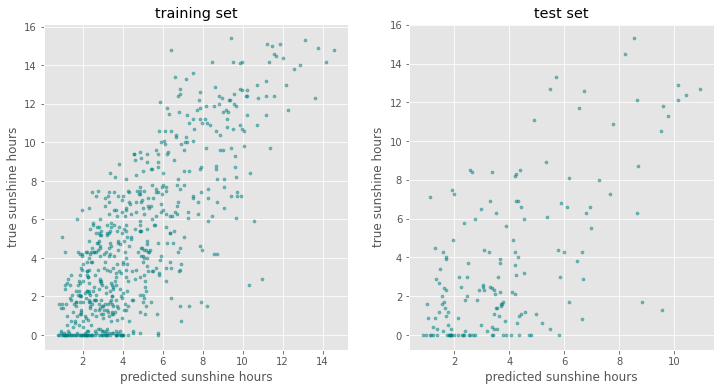

In [108]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plt.style.use('ggplot')
axes[0].scatter(y_train_predicted, y_train_undersampling, s=10, alpha=0.5, color="teal")
axes[0].set_title("training set")
axes[0].set_xlabel("predicted sunshine hours")
axes[0].set_ylabel("true sunshine hours")

axes[1].scatter(y_test_predicted, y_test, s=10, alpha=0.5, color="teal")
axes[1].set_title("test set")
axes[1].set_xlabel("predicted sunshine hours")
axes[1].set_ylabel("true sunshine hours")

#plt.savefig("03_regression_compare_training_test_4_dropout_oversampling.png", dpi=200)

In [45]:
from imblearn.over_sampling import SMOTE #, ADASYN

In [46]:
y_train[:30].values

array([ 1.5,  2.5,  0. , 10.8,  5.4,  0.9,  9.9,  8.1,  1.2,  4.8,  0. ,
        0.1,  0. ,  0. , 11. ,  1.2,  0. ,  5.6, 12.4,  0.7,  7.5,  0.7,
        0.4,  2.6,  0. ,  0. ,  0.2,  8.7,  9. ,  8.4])

In [47]:
X_train.shape, y_train.shape

((767, 163), (767,))

In [48]:
from imblearn.over_sampling import SMOTE, ADASYN
X_resampled, y_resampled = SMOTE(k_neighbors=3).fit_resample(X_train, y_train.values.astype(int))

In [49]:
X_resampled.shape, X_train.shape

((4032, 163), (767, 163))

(array([252., 252., 252., 252., 252., 252., 252., 252., 252., 252., 252.,
        252., 252., 252., 252., 252.,   0.,   0.,   0.,   0.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20.]),
 <BarContainer object of 20 artists>)

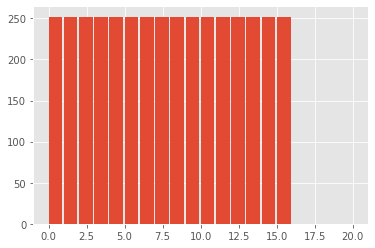

In [57]:
plt.hist(y_resampled, np.linspace(0,20,21), width=0.9)

In [60]:
from tensorflow.keras.layers import Dropout

def create_nn(n_features, n_predictions):
    # Input layer
    layers_input = Input(shape=(n_features,), name='input')

    # Dense layers
    layers_dense = BatchNormalization()(layers_input)
    layers_dense = Dense(100, 'relu')(layers_dense)
    layers_dense = Dropout(rate=0.2)(layers_dense)
    layers_dense = Dense(50, 'relu')(layers_dense)
    layers_dense = Dropout(rate=0.2)(layers_dense)
    layers_dense = Dense(10, 'relu')(layers_dense)

    # Output layer
    layers_output = Dense(n_predictions)(layers_dense)

    # Defining the model and compiling it
    return Model(inputs=layers_input, outputs=layers_output, name="dropout_prediction_model")

model = create_nn(X_data.shape[1], 1)
model.compile(loss='mse', optimizer=Adam(1e-4), metrics=[tf.keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "dropout_prediction_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 163)]             0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 163)               652       
_________________________________________________________________
dense_23 (Dense)             (None, 100)               16400     
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_7 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 10)   

In [61]:
history = model.fit(X_resampled, y_resampled,
                    batch_size = 50,
                    epochs = 200,
                    validation_data=(X_val, y_val),
                    verbose = 2)

Epoch 1/200
81/81 - 1s - loss: 63.9884 - root_mean_squared_error: 7.9993 - val_loss: 14.5495 - val_root_mean_squared_error: 3.8144
Epoch 2/200
81/81 - 0s - loss: 36.7206 - root_mean_squared_error: 6.0598 - val_loss: 16.6119 - val_root_mean_squared_error: 4.0758
Epoch 3/200
81/81 - 0s - loss: 21.3645 - root_mean_squared_error: 4.6222 - val_loss: 16.9048 - val_root_mean_squared_error: 4.1115
Epoch 4/200
81/81 - 0s - loss: 17.7117 - root_mean_squared_error: 4.2085 - val_loss: 14.4518 - val_root_mean_squared_error: 3.8015
Epoch 5/200
81/81 - 0s - loss: 15.6255 - root_mean_squared_error: 3.9529 - val_loss: 12.8474 - val_root_mean_squared_error: 3.5843
Epoch 6/200
81/81 - 0s - loss: 13.5965 - root_mean_squared_error: 3.6873 - val_loss: 12.0610 - val_root_mean_squared_error: 3.4729
Epoch 7/200
81/81 - 0s - loss: 12.1997 - root_mean_squared_error: 3.4928 - val_loss: 11.6301 - val_root_mean_squared_error: 3.4103
Epoch 8/200
81/81 - 0s - loss: 11.2622 - root_mean_squared_error: 3.3559 - val_loss

Epoch 64/200
81/81 - 0s - loss: 4.4429 - root_mean_squared_error: 2.1078 - val_loss: 11.1137 - val_root_mean_squared_error: 3.3337
Epoch 65/200
81/81 - 0s - loss: 4.2652 - root_mean_squared_error: 2.0652 - val_loss: 11.1551 - val_root_mean_squared_error: 3.3399
Epoch 66/200
81/81 - 0s - loss: 4.2406 - root_mean_squared_error: 2.0593 - val_loss: 10.9392 - val_root_mean_squared_error: 3.3075
Epoch 67/200
81/81 - 0s - loss: 4.3465 - root_mean_squared_error: 2.0848 - val_loss: 10.9115 - val_root_mean_squared_error: 3.3033
Epoch 68/200
81/81 - 0s - loss: 4.2171 - root_mean_squared_error: 2.0536 - val_loss: 10.9816 - val_root_mean_squared_error: 3.3139
Epoch 69/200
81/81 - 0s - loss: 4.1888 - root_mean_squared_error: 2.0467 - val_loss: 11.0420 - val_root_mean_squared_error: 3.3230
Epoch 70/200
81/81 - 0s - loss: 4.2180 - root_mean_squared_error: 2.0538 - val_loss: 11.0704 - val_root_mean_squared_error: 3.3272
Epoch 71/200
81/81 - 0s - loss: 4.3464 - root_mean_squared_error: 2.0848 - val_loss

Epoch 127/200
81/81 - 0s - loss: 3.0205 - root_mean_squared_error: 1.7380 - val_loss: 10.3973 - val_root_mean_squared_error: 3.2245
Epoch 128/200
81/81 - 0s - loss: 3.0253 - root_mean_squared_error: 1.7393 - val_loss: 10.4270 - val_root_mean_squared_error: 3.2291
Epoch 129/200
81/81 - 0s - loss: 3.0528 - root_mean_squared_error: 1.7472 - val_loss: 10.4233 - val_root_mean_squared_error: 3.2285
Epoch 130/200
81/81 - 0s - loss: 3.0040 - root_mean_squared_error: 1.7332 - val_loss: 10.2216 - val_root_mean_squared_error: 3.1971
Epoch 131/200
81/81 - 0s - loss: 2.9494 - root_mean_squared_error: 1.7174 - val_loss: 10.4704 - val_root_mean_squared_error: 3.2358
Epoch 132/200
81/81 - 0s - loss: 2.9584 - root_mean_squared_error: 1.7200 - val_loss: 10.4873 - val_root_mean_squared_error: 3.2384
Epoch 133/200
81/81 - 0s - loss: 2.8597 - root_mean_squared_error: 1.6911 - val_loss: 10.4228 - val_root_mean_squared_error: 3.2284
Epoch 134/200
81/81 - 0s - loss: 3.0141 - root_mean_squared_error: 1.7361 - 

81/81 - 0s - loss: 2.4145 - root_mean_squared_error: 1.5539 - val_loss: 10.0050 - val_root_mean_squared_error: 3.1631
Epoch 190/200
81/81 - 0s - loss: 2.4119 - root_mean_squared_error: 1.5530 - val_loss: 10.0755 - val_root_mean_squared_error: 3.1742
Epoch 191/200
81/81 - 0s - loss: 2.3482 - root_mean_squared_error: 1.5324 - val_loss: 10.1591 - val_root_mean_squared_error: 3.1873
Epoch 192/200
81/81 - 0s - loss: 2.2658 - root_mean_squared_error: 1.5053 - val_loss: 10.1421 - val_root_mean_squared_error: 3.1847
Epoch 193/200
81/81 - 0s - loss: 2.3719 - root_mean_squared_error: 1.5401 - val_loss: 10.4027 - val_root_mean_squared_error: 3.2253
Epoch 194/200
81/81 - 0s - loss: 2.3055 - root_mean_squared_error: 1.5184 - val_loss: 10.3406 - val_root_mean_squared_error: 3.2157
Epoch 195/200
81/81 - 0s - loss: 2.4306 - root_mean_squared_error: 1.5590 - val_loss: 10.2151 - val_root_mean_squared_error: 3.1961
Epoch 196/200
81/81 - 0s - loss: 2.2177 - root_mean_squared_error: 1.4892 - val_loss: 10.1

Text(0, 0.5, 'RMSE')

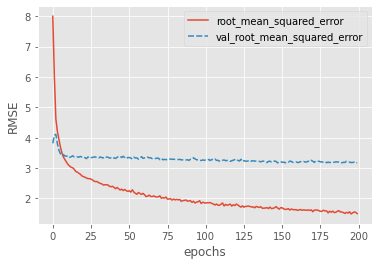

In [62]:
history_df = pd.DataFrame.from_dict(history.history)
sns.lineplot(data=history_df[['root_mean_squared_error', 'val_root_mean_squared_error']])
plt.xlabel("epochs")
plt.ylabel("RMSE")
#plt.savefig("03_training_history_5_rmse_dropout_oversampling.png", dpi=200)

In [63]:
# Predict the sunshine hours
y_train_predicted = model.predict(X_train)
y_test_predicted = model.predict(X_test)

Text(0, 0.5, 'true sunshine hours')

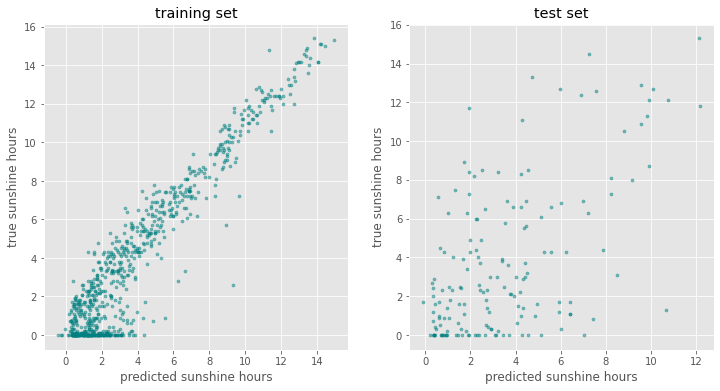

In [64]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plt.style.use('ggplot')
axes[0].scatter(y_train_predicted, y_train, s=10, alpha=0.5, color="teal")
axes[0].set_title("training set")
axes[0].set_xlabel("predicted sunshine hours")
axes[0].set_ylabel("true sunshine hours")

axes[1].scatter(y_test_predicted, y_test, s=10, alpha=0.5, color="teal")
axes[1].set_title("test set")
axes[1].set_xlabel("predicted sunshine hours")
axes[1].set_ylabel("true sunshine hours")

#plt.savefig("03_regression_compare_training_test_4_dropout_oversampling.png", dpi=200)

Text(0, 0.5, 'true values')

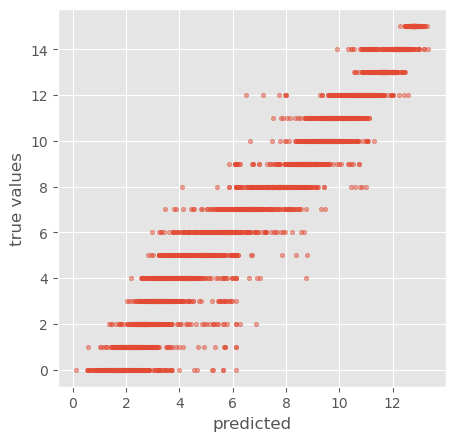

In [115]:
y_predicted = model.predict(X_resampled)

plt.figure(figsize=(5, 5), dpi=100)
plt.scatter(y_predicted, y_resampled, s=10, alpha=0.5)
plt.xlabel("predicted")
plt.ylabel("true values")

Text(0, 0.5, 'true values')

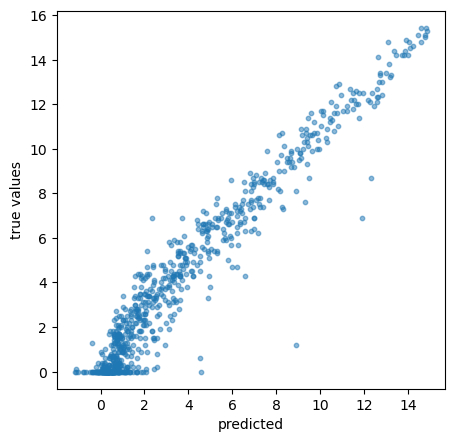

In [28]:
y_predicted = model.predict(X_train)

plt.figure(figsize=(5, 5), dpi=100)
plt.scatter(y_predicted, Y_train, s=10, alpha=0.5)
plt.xlabel("predicted")
plt.ylabel("true values")

Text(0, 0.5, 'true values')

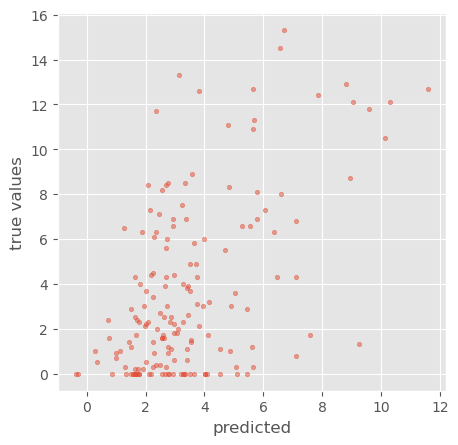

In [117]:
y_predicted = model.predict(X_test)

plt.figure(figsize=(5, 5), dpi=100)
plt.scatter(y_predicted, y_test, s=10, alpha=0.5)
plt.xlabel("predicted")
plt.ylabel("true values")

In [ ]:
>>> print(sorted(Counter(y_resampled).items()))
[(0, 4674), (1, 4674), (2, 4674)]
>>> clf_smote = LinearSVC().fit(X_resampled, y_resampled)
>>> X_resampled, y_resampled = ADASYN().fit_resample(X, y)
>>> print(sorted(Counter(y_resampled).items()))
[(0, 4673), (1, 4662), (2, 4674)]
>>> clf_adasyn = LinearSVC().fit(X_resampled, y_resampled)

In [72]:
from tensorflow.keras.optimizers import Adam


n_features = X_data.shape[1]
n_predictions = 1

# Input layer
layers_input = Input(shape=(n_features,), name='input')

# Dense layers
layers_dense = BatchNormalization()(layers_input)
layers_dense = Dense(100, 'relu')(layers_dense)
layers_dense = BatchNormalization()(layers_dense)
layers_dense = Dense(50, 'relu')(layers_dense)

# Output layer
layers_output = Dense(n_predictions)(layers_dense)

# Defining the model and compiling it
model = Model(inputs=layers_input, outputs=layers_output)
model.compile(loss='mae', optimizer=Adam(lr=1e-3), metrics=['mse', 'mae'])

model.summary()

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 144)]             0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 144)               576       
_________________________________________________________________
dense_53 (Dense)             (None, 100)               14500     
_________________________________________________________________
batch_normalization_7 (Batch (None, 100)               400       
_________________________________________________________________
dense_54 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_55 (Dense)             (None, 1)                 51        
Total params: 20,577
Trainable params: 20,089
Non-trainable params: 488
____________________________________________________

In [73]:
history = model.fit(X_train, Y_train,
                    batch_size = 50,
                    epochs = 200,
                    validation_data=(X_val, Y_val), verbose = 2)

Epoch 1/200
16/16 - 1s - loss: 0.6334 - mse: 0.7276 - mae: 0.6334 - val_loss: 1.7523 - val_mse: 3.8652 - val_mae: 1.7523
Epoch 2/200
16/16 - 0s - loss: 0.3956 - mse: 0.2690 - mae: 0.3956 - val_loss: 1.2346 - val_mse: 2.0190 - val_mae: 1.2346
Epoch 3/200
16/16 - 0s - loss: 0.3353 - mse: 0.2029 - mae: 0.3353 - val_loss: 0.9240 - val_mse: 1.1707 - val_mae: 0.9240
Epoch 4/200
16/16 - 0s - loss: 0.3018 - mse: 0.1631 - mae: 0.3018 - val_loss: 0.8598 - val_mse: 1.1316 - val_mae: 0.8598
Epoch 5/200
16/16 - 0s - loss: 0.2703 - mse: 0.1401 - mae: 0.2703 - val_loss: 0.5638 - val_mse: 0.4802 - val_mae: 0.5638
Epoch 6/200
16/16 - 0s - loss: 0.2437 - mse: 0.1113 - mae: 0.2437 - val_loss: 0.5329 - val_mse: 0.4376 - val_mae: 0.5329
Epoch 7/200
16/16 - 0s - loss: 0.2349 - mse: 0.1087 - mae: 0.2349 - val_loss: 0.5229 - val_mse: 0.4119 - val_mae: 0.5229
Epoch 8/200
16/16 - 0s - loss: 0.2224 - mse: 0.0917 - mae: 0.2224 - val_loss: 0.4122 - val_mse: 0.2680 - val_mae: 0.4122
Epoch 9/200
16/16 - 0s - loss: 0

Epoch 69/200
16/16 - 0s - loss: 0.0963 - mse: 0.0200 - mae: 0.0963 - val_loss: 0.2249 - val_mse: 0.1231 - val_mae: 0.2249
Epoch 70/200
16/16 - 0s - loss: 0.1044 - mse: 0.0219 - mae: 0.1044 - val_loss: 0.2356 - val_mse: 0.1213 - val_mae: 0.2356
Epoch 71/200
16/16 - 0s - loss: 0.1036 - mse: 0.0225 - mae: 0.1036 - val_loss: 0.2144 - val_mse: 0.1153 - val_mae: 0.2144
Epoch 72/200
16/16 - 0s - loss: 0.0940 - mse: 0.0193 - mae: 0.0940 - val_loss: 0.2174 - val_mse: 0.1149 - val_mae: 0.2174
Epoch 73/200
16/16 - 0s - loss: 0.1055 - mse: 0.0246 - mae: 0.1055 - val_loss: 0.2126 - val_mse: 0.1106 - val_mae: 0.2126
Epoch 74/200
16/16 - 0s - loss: 0.0954 - mse: 0.0215 - mae: 0.0954 - val_loss: 0.2192 - val_mse: 0.1188 - val_mae: 0.2192
Epoch 75/200
16/16 - 0s - loss: 0.1004 - mse: 0.0212 - mae: 0.1004 - val_loss: 0.2127 - val_mse: 0.1179 - val_mae: 0.2127
Epoch 76/200
16/16 - 0s - loss: 0.1001 - mse: 0.0215 - mae: 0.1001 - val_loss: 0.2146 - val_mse: 0.1174 - val_mae: 0.2146
Epoch 77/200
16/16 - 0s 

Epoch 136/200
16/16 - 0s - loss: 0.0789 - mse: 0.0132 - mae: 0.0789 - val_loss: 0.1957 - val_mse: 0.0974 - val_mae: 0.1957
Epoch 137/200
16/16 - 0s - loss: 0.0773 - mse: 0.0135 - mae: 0.0773 - val_loss: 0.1917 - val_mse: 0.0932 - val_mae: 0.1917
Epoch 138/200
16/16 - 0s - loss: 0.0796 - mse: 0.0126 - mae: 0.0796 - val_loss: 0.1924 - val_mse: 0.0923 - val_mae: 0.1924
Epoch 139/200
16/16 - 0s - loss: 0.0717 - mse: 0.0114 - mae: 0.0717 - val_loss: 0.1937 - val_mse: 0.0939 - val_mae: 0.1937
Epoch 140/200
16/16 - 0s - loss: 0.0700 - mse: 0.0110 - mae: 0.0700 - val_loss: 0.1997 - val_mse: 0.1031 - val_mae: 0.1997
Epoch 141/200
16/16 - 0s - loss: 0.0805 - mse: 0.0147 - mae: 0.0805 - val_loss: 0.2070 - val_mse: 0.1046 - val_mae: 0.2070
Epoch 142/200
16/16 - 0s - loss: 0.0758 - mse: 0.0131 - mae: 0.0758 - val_loss: 0.2035 - val_mse: 0.1060 - val_mae: 0.2035
Epoch 143/200
16/16 - 0s - loss: 0.0754 - mse: 0.0122 - mae: 0.0754 - val_loss: 0.1972 - val_mse: 0.0960 - val_mae: 0.1972
Epoch 144/200
16

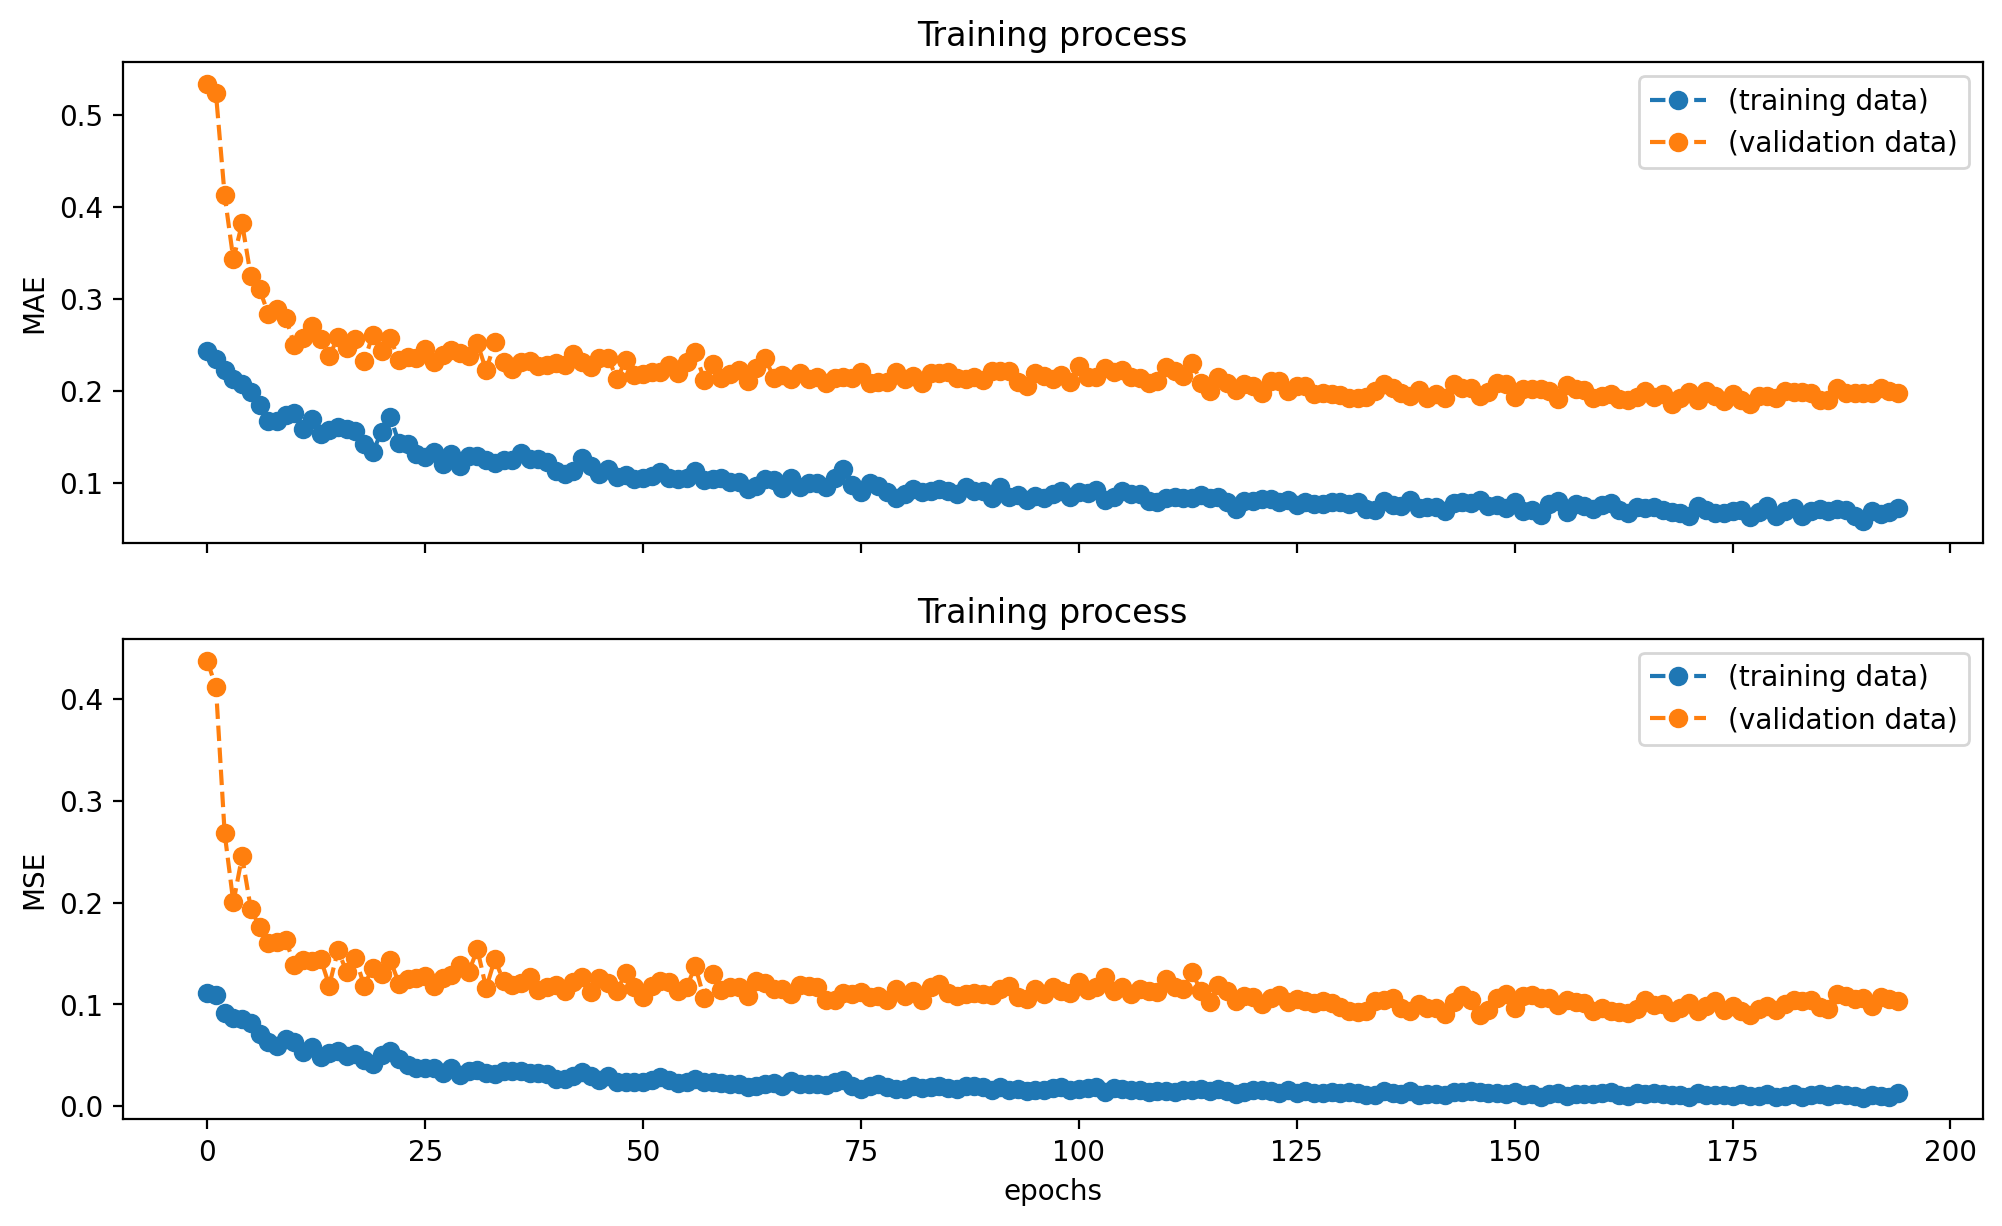

In [74]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,7), dpi=200)

ax1.plot(history.history['mae'][5:], "o--", label='(training data)')
ax1.plot(history.history['val_mae'][5:], "o--", label='(validation data)')
ax1.set_title('Training process')
ax1.set_ylabel("MAE")
ax1.legend()

ax2.plot(history.history['mse'][5:], "o--", label='(training data)')
ax2.plot(history.history['val_mse'][5:], "o--", label='(validation data)')
ax2.set_title('Training process')
ax2.set_ylabel("MSE")
ax2.set_xlabel("epochs")
ax2.legend()